# Report4 - 俄罗斯方块

* 姓名：刘权祥
* 学号：2019300414




## 内容：

* 任务类型：强化学习
* 背景介绍：俄罗斯方块、五子棋是两个经典的休闲游戏。
  * 俄罗斯方块的基本规则是移动、旋转和摆放游戏自动输出的各种方块，使之排列成完整的一行或多行并且消除得分。
  * 五子棋是一种两人对弈的纯策略型棋类游戏。通常双方分别使用黑白两色的棋子，下在棋盘直线与横线的交叉点上，先形成5子连线者获胜。

选择一个游戏（俄罗斯方块、五子棋其中一个）实现计算机自动玩游戏：通过构建游戏仿真环境，并研究强化学习方法，让计算机自动计算最优的策略，从而实现让计算机自动玩。


## 要求：

1. 研究[OpenAI Gym](https://gym.openai.com/)，编写游戏的仿真环境
2. 研究深度强化学习模型，构建游戏的模型
3. 研究并编写基于PyTorch的代码
4. 测试所研究方法的效果
5. 自己手动编写一个不用机器学习，通过规则实现的方法；然后让机器学习方法和自己编写的规则的方法对弈
6. 按照`report_template.ipynb`撰写自己的报告。



## 任务分析

在这个任务中，我打算选择俄罗斯方块作为目标。

在查看OpenAI Gym的教程时，我发现已经有比较好的Tetris实现了，并且可以通过`pip install gym-tetris`直接安装使用。考虑到自己实现一遍Tetris，并且把各种数据接口写好以满足机器学习的需要会比较花时间，所以我打算直接使用gym-tetris提供的俄罗斯方块仿真环境。

根据网上的资料，大家都是使用DQN来学习俄罗斯方块的，所以这个任务中我也打算自己实现一个DQN来学习俄罗斯方块。

因此，在这个任务中，我打算进行以下工作：

1. 了解gym-tetris中的数据

2. 学习DQN的基础知识

3. 构建DQN并进行训练

4. 测试DQN的效果

5. 尝试编写基于规则的算法

## 俄罗斯方块背景知识
> 这部分是从网上找到的。

- **为啥叫俄罗斯方块？**：首先俄罗斯方块是一个俄罗斯人做的，这个无聊的人就是前苏联科学家阿列克谢·帕基特诺夫

- **俄罗斯方块会结束吗？**：在1997年Heidi Burgiel根据极大极小值算法证明了**完全随机的俄罗斯方块游戏最终一定会结束。** 于是大家的热情转向了怎样才能让俄罗斯方块得到更高的分数，在2009年的时候，世界最优的俄罗斯方块的智能算法（by Thiery & Scherrer）是可以平均消除3500万行的

- 俄罗斯方块的智能算法的类型，基本上有one-piece和two-piece两种，就是仅考虑当前方块和把下一个方块也纳入考虑范围两种算法。但实际上，one-piece算法相对简单一些，而且不比two-piece差，甚至还要强。

## 解读gym-tetris中的数据

这里我使用的是已经有的Tetris实现，并且是通过`pip`安装的。为了能够成功的将DQN应用与Tetris，我们需要先搞清楚gym-tetris中的数据。



Tetris的官方demo如下所示。

In [15]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT

env = gym_tetris.make('TetrisA-v0')
env = JoypadSpace(env, MOVEMENT)

done = True
for step in range(100):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

根据官方的demo，我们发现`state, reward, done, info = env.step(env.action_space.sample())` 这条语句中出现的数据应该是比较重要的。我们可以对其具体的分析:

```
state type: <class 'numpy.ndarray'>		
state shape: (240, 256, 3)

reward type: <class 'numpy.int64'>		
reward shape: ()

done type: <class 'bool'>	            
done shape: ()

info type: <class 'dict'>		        
info shape: ()

action type: <class 'int'>		        
action shape: ()
```

上面是每一个数据的具体属性，其中：

- state是目前的游戏界面，是240\*256的像素点，有三个通道！需要注意的是state包括了整个游戏界面，而我们需要的只是中间的一部分。

- reward顾名思义，就是当前一步之后得到的奖励

- done标志着游戏是否结束

- info是具体的一些信息，包括当前的方块、接下来的方块、分数、等。

- env.step()中的参数是action，标志着方块的运动方式

根据上面的分析，我们需要做的事情就比较明确了：

1. 首先我们需要对state进行处理，提取出我们需要的游戏界面，将其作为当前游戏的状态。

2. 之后我们把state输入我们要搭建的网络，让网络根据reward来学习如何输出action

由于done对于网络没有意义，而info中的信息不好提取和使用，所以没有考虑使用这两个数据。

### 处理state

我们可以通过下面的函数把state处理成一个非常简单的矩阵（用0表示空，用1表示放置了方块），并且输出展开后的矩阵。

In [16]:
import cv2.cv2 as cv
import numpy as np

def get_matrix(state, show_detail=True):
    """
    俄罗斯方块的初始state是包括了整个界面的，但我们需要的是游戏界面
    这个函数直接从state中分割出了游戏界面的矩阵，并且进行了阈值化处理
    这个游戏是10*20的，所以最后直接输出10*20的矩阵！
    :param state: game state
    :return: game matrix
    """
    state = cv.cvtColor(state, cv.COLOR_RGB2GRAY)
    _, state = cv.threshold(state, 0, 255, cv.THRESH_BINARY)
    state = state[49:208, 95:176]  # (161, 81)
    # 这里需要推一个计算公式，把163*82的矩阵转化为20*10的矩阵！【done】
    #  已知 方块大小为7*7，163*82
    game_state = np.zeros((20, 10))
    for i in range(20):
        for j in range(10):
            game_state[i, j] = 1 if state[i * 8 + 3, j * 8 + 3] == 255 else 0
    if show_detail:
        print("\n==================================")
        print(game_state)
        print("==================================\n")
        cv.imshow("test", state)
        if cv.waitKey(1) == 112:
            cv.waitKey(0)
    return game_state.flatten()

这份部分的运行过程如下图所示：（俄罗斯方块的一些结果保存不到notebook里）

初始游戏界面：

![origin.png](./img/origin.png)

提取关键的部分并且进行二值化：

![processing.png](./img/processing.png)

之后把二值化的图转化成10\*20的矩阵再展开输出即可，最后的结果如下（有放大）。

<img src="./img/result.png" alt="result"  width="80px" />

## DQN自动玩俄罗斯方块

### DQN构建与训练

#### 搭建DQN网络

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from gym_tetris.actions import SIMPLE_MOVEMENT

# 超参数
BATCH_SIZE = 128  # 样本数量
LR = 0.001  # 学习率
EPSILON = 0.9  # greedy policy
GAMMA = 0.9  # reward discount
TARGET_REPLACE_ITER = 100  # 目标网络更新频率
MEMORY_CAPACITY = 20000  # 记忆库容量
N_ACTIONS = len(SIMPLE_MOVEMENT)  # 俄罗斯方块动作个数（这里如果效果不好，后面就换成SIMPLE_MOVEMENT）
N_STATES = 20 * 10  # 俄罗斯方块的状态矩阵


# 定义Net类 (定义网络)
class Net(nn.Module):
    # 定义Net的一系列属性
    def __init__(self):
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, N_ACTIONS)

        # 权重初始化 (均值为0，方差为0.1的正态分布)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4.weight.data.normal_(0, 0.1)

    # 定义forward函数 (x为状态)
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        # 连接输入层到隐藏层，且使用激励函数ReLU来处理经过隐藏层后的值
        out = F.relu(out)
        # 连接隐藏层到输出层，获得最终的输出值 (即动作值)
        out = self.fc4(out)
        # 链接一个softmax函数
        out = F.softmax(out, dim=1)
        # 返回动作值，shape为(1,6)
        return out


# 定义DQN类 (定义两个网络)
class DQN(object):
    # 定义DQN的一系列属性
    def __init__(self):
        #  两个网络是为了增加DQN的稳定性
        self.eval_net, self.target_net = Net(), Net()  # 利用Net创建两个神经网络: 评估网络和目标网络
        self.learn_step_counter = 0  # for target updating
        self.memory_counter = 0  # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))  # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)  # 使用Adam优化器 (输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()  # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)
        # self.loss_func = nn.CrossEntropyLoss()  # 使用交叉熵损失函数(不太好使用)

    def choose_action(self, x):  # 定义动作选择函数 (x为状态)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)  # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        if np.random.uniform() < EPSILON:  # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            actions_value = self.eval_net.forward(x)  # 通过对评估网络输入状态x，前向传播获得动作值
            action = torch.max(actions_value, 1)[1].data.numpy()  # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]  # 输出action的第一个数
        else:  # 随机选择动作
            action = np.random.randint(0, N_ACTIONS)  # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action  # 返回选择的动作 (0或1)

    def store_transition(self, s, a, r, s_):  # 定义记忆存储函数 (这里输入为一个transition)
        # 状态、动作、奖励、状态
        transition = np.hstack((s, [a, r], s_))  # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY  # 获取transition要置入的行数
        self.memory[index, :] = transition  # 置入transition
        self.memory_counter += 1  # memory_counter自加1

    def learn(self):  # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:  # 一开始触发，然后每100步触发
            # TODO 这种方法和深拷贝哪一种更好？？？
            self.target_net.load_state_dict(self.eval_net.state_dict())  # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1  # 学习步数自加1

        # 抽取记忆库中的批数据，可能会重复
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES + 1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES + 1:N_STATES + 2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_next = self.target_net(b_s_).detach()
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # 输入32个评估值和32个目标值，使用均方损失函数
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()  # 清空上一步的残余更新参数值
        loss.backward()  # 误差反向传播, 计算参数更新值
        self.optimizer.step()  # 更新评估网络的所有参数

        return loss.item()

    def save(self):
        torch.save(self.eval_net.state_dict(), "./data/DQN_eval_net.pth")
        torch.save(self.target_net.state_dict(), "./data/DQN_target_net.pth")

    def load(self):
        self.eval_net.load_state_dict(torch.load("./data/DQN_eval_net.pth"))
        self.target_net.load_state_dict(torch.load("./data/DQN_target_net.pth"))


#### 训练DQN网络

> 如果在notebook中训练的话，下面只会输出具体的数据

In [28]:
import gym_tetris
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

import src_old.report_04_tools as tools
from src_old.Tetris_DQN import DQN, MEMORY_CAPACITY

# Open AI gym提供了许多不同的环境。每一个环境都有一套自己的参数和方法。然而，他们通常由一个类Env包装（就像这是面向对象编程语言（OOPLs）的一个接口）。这个类暴露了任一环境的最常用的，最本质的方法，比如step
# ，reset，seed。拥有这个“接口”类非常好，因为它允许您的代码不受环境限制。如果您希望在不同的环境中测试单个代理，那么它还使事情变得更简单。然而，如果你想访问一个特定环境的场景动态后面的东西，需要使用unwrapped属性。
# 还原env的原始设置，env外包了一层防作弊层
# env = gym_tetris.make('TetrisA-v0').unwrapped
# 这里采用一种奖励分数惩罚身高的俄罗斯方块
env = gym_tetris.make('TetrisA-v0').unwrapped
env = JoypadSpace(env, SIMPLE_MOVEMENT)

dqn = DQN()
#dqn.load('./src_old/data/')  # 使用已有的模型继续训练
dqn.eval_net.load_state_dict(torch.load("./src_old/data/DQN_eval_net.pth"))
dqn.target_net.load_state_dict(torch.load("./src_old/data/DQN_target_net.pth"))

loss = float('inf')
loss_list = open('./src_old/data/loss_list_demo.dat', 'w')
reward_sum = open('./src_old/data/reward_sum_demo.dat', 'w')

for i in range(30):  # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    last_state = env.reset()  # 重置环境
    last_state = tools.get_matrix(last_state)
    last_score = 0

    episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励

    if (i + 1) % 50 == 0:  # 防止i=0，还没开始训练的时候就保存模型
        print("save model")
        dqn.save()

    while True:  # 开始一个episode (每一个循环代表一步)
        # if i % 50 == 0:
        #     env.render()  # 显示实验动画
        env.render()  # 显示实验动画
        action = dqn.choose_action(last_state)  # 输入该步对应的状态s，选择动作
        state, reward, done, info = env.step(action)  # 执行动作，获得反馈
        state = tools.get_matrix(state)

        # ===========================奖励修改部分===========================
        # TODO
        # =================================================================

        dqn.store_transition(last_state, action, reward, state)  # 存储样本
        episode_reward_sum += reward  # 逐步加上一个episode内每个step的reward

        last_state = state  # 更新状态
        last_action = action  # 更新动作

        if dqn.memory_counter > MEMORY_CAPACITY:  # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            loss = dqn.learn()

        if done:  # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            print('episode%s---loss: %s' % (i, loss))

            loss_list.write(str(loss) + "\n")
            reward_sum.write(str(episode_reward_sum) + "\n")

            break

loss_list.close()
reward_sum.close()


<<<<<<<<<Episode: 0
episode0---reward_sum: 0
episode0---loss: inf
<<<<<<<<<Episode: 1
episode1---reward_sum: 0
episode1---loss: 2.345542270631995e-05
<<<<<<<<<Episode: 2
episode2---reward_sum: 51
episode2---loss: 0.497623473405838
<<<<<<<<<Episode: 3
episode3---reward_sum: 85
episode3---loss: 0.001480446313507855
<<<<<<<<<Episode: 4
episode4---reward_sum: 70
episode4---loss: 0.0013907753163948655
<<<<<<<<<Episode: 5
episode5---reward_sum: 67
episode5---loss: 0.006195139605551958
<<<<<<<<<Episode: 6
episode6---reward_sum: 55
episode6---loss: 0.005188534036278725
<<<<<<<<<Episode: 7
episode7---reward_sum: 51
episode7---loss: 0.9428956508636475
<<<<<<<<<Episode: 8
episode8---reward_sum: 66
episode8---loss: 0.6294727325439453
<<<<<<<<<Episode: 9
episode9---reward_sum: 46
episode9---loss: 0.0018780736718326807
<<<<<<<<<Episode: 10
episode10---reward_sum: 59
episode10---loss: 0.19566214084625244
<<<<<<<<<Episode: 11
episode11---reward_sum: 67
episode11---loss: 0.00395326130092144
<<<<<<<<<Ep

#### 可视化训练中损失与奖励

在notebook中训练的轮数非常少，训练中的奖励与损失是下面这样的，看起来并不稳定。

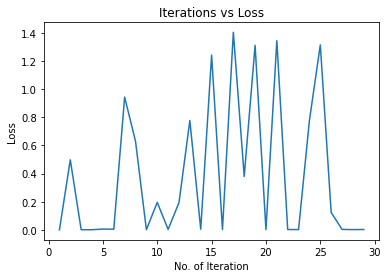

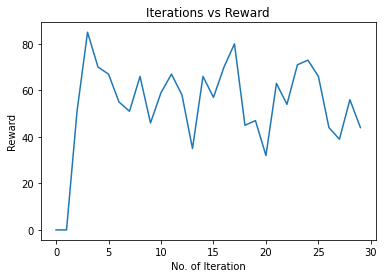

In [29]:
import matplotlib.pyplot as plt

loss_file = open('./src_old/data/loss_list_demo.dat', 'r')
reward_file = open('./src_old/data/reward_sum_demo.dat', 'r')

loss_list = []
reward_list = []

for loss in loss_file:
    loss_list.append(float(loss))

for reward in reward_file:
    reward_list.append(float(reward))

plt.figure(1)
plt.plot(list(range(len(loss_list))), loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")

plt.figure(2)
plt.plot(list(range(len(reward_list))), reward_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Reward")
plt.title("Iterations vs Reward")

plt.show()


### 奖励函数设计

奖励函数这部分走了特别多的弯路，之前觉得不是很有必要，但后面我觉得**奖励函数的设计应该是整个过程中最最重要的一环！**

1. **最初不打算设计奖励函数**

一开始其实没有考虑奖励函数的问题，认为使用tetris自带的奖励，最多收敛的慢一些，多训练训练也可以出结果，但是最后训练了四个多小时，也没看到结果变好，最后可能就收敛到得分50多的情况，并且DQN满足于这个得分，都不再进行其他尝试了。

所以Tetris自带的奖励系统可能无法满足训练的需要，鉴于这种情况，我开始尝试设计奖励函数。

2. **设计了错误的奖励机制**

之后尝试设计奖励的时候比较天真，甚至连用的俄罗斯方块的源代码都没好好看，直接就去设计奖励了。

当时设计的奖励内容大概是这样的：

    1. 奖励下落，惩罚长期不下落
    
    2. 奖励旋转，惩罚连续旋转
    
    3. 奖励层数低的方块数目，惩罚层数高的方块数目
    
上面这个奖励的逻辑其实大体没问题，但是我**每次计算出奖励之后就直接加到了俄罗斯方块自己计算出来的奖励里面，问题主要是出在这里。** 这么做的结果就是：每运行一个回合之后，奖励要么非常非常大，要么非常非常小。（因为**每一步得到的是整局的奖励**，这样累加起来数值就非常可观）

当时其实觉得很奇怪，但是没有意识到问题，训练了很长时间收敛到一个很小的奖励值（大概50左右）的时候，我才觉得这里会有问题。

观察俄罗斯方块源代码部分（如下），我们可以知道计算奖励的时候是计算这次的分数与上一次的分数的差值，而我一开始设置的奖励就很明显不合理。

``` python

    def _get_reward(self):
        """Return the reward after a step occurs."""
        reward = 0
        # reward the change in score
        if self._reward_score:
            reward += self._score - self._current_score
        # reward a line being cleared
        if self._reward_lines:
            reward += self._number_of_lines - self._current_lines
        # penalize a change in height
        if self._penalize_height:
            penalty = self._board_height - self._current_height
            # only apply the penalty for an increase in height (not a decrease)
            if penalty > 0:
                reward -= penalty
        # update the locals
        self._current_score = self._score
        self._current_lines = self._number_of_lines
        self._current_height = self._board_height

        return reward

```

3. **尝试奖励函数的设计**

在知道了问题所在之后，我就开始设计奖励函数了，根据之前已经发现的问题，这次我打算**直接计算出一个分数来，本次的分数与上次的分数相减就是本次的奖励。** 

在第2阶段的时候，因为对action做一些限制并没有得到很好的效果，所以这里我打算仅仅根据state来计算分数和奖励。

其中一种奖励策略的实现是这样的：

In [2]:
# 这个的策略是：
#  1. 奖励最大宽度
#  2. 奖励宽度大的行数
#  3. 惩罚最大身高 （希望越低越好）
#  3. 惩罚最大宽度与最小宽度之间的距离（希望越平均越好）
def score_policy_A(state, action=None):
    state = state.reshape(20, 10)
    h = 0  # 竖直方向上最大方块数目
    w = 0  # 水平方向上最大方块数目
    w_ = 1  # 水平方向上最小方块数目
    w_x = 0  # 水平方向上宽度大于6的行数
    for i in range(20):  # 每一行
        w_count = 0
        for j in range(10):  # 这行中的元素
            if state[i, j] != 0:
                w_count += 1
        if w_count != 0:
            w = w if w_count < w else w_count
            w_ = w_ if w_count > w_ else w_count
            h += 1
        if w_count > 5:
            w_x += 1
    score = w * 8 + w_ * 50 + w_x * 30 - h * 12  # 手动的改改权重
    return score

4. **设计更加合理的奖励函数**

设计了上面的奖励函数之后我又训练了几个小时，这次的效果比之前的好了特别多，至少DQN现在知道了应该尽可能的往下面放方块，并且会尝试着增加每一行的宽度，但是训练出来的效果其实也不是特别好，DQN在下面十层能够好好地堆叠方块，在上面十层就只会一直增加高度，并且除非是很偶然的情况，否则DQN也无法消除行。

之后我在查看每一步的奖励的时候发现了问题：**之前设计的奖励函数可能更偏重于整个局面的合理性，尽管前后两次分数的差能计算出单独一步的奖励来，但这个奖励并不是合理的！**

我感觉设计一个合理的奖励函数比较困难，需要不断调整和观察每一步得到的奖励。在尝试了一段时间后，我设计出的奖励函数如下所示：

In [3]:
def get_height(matrix):
    """
    计算state中的高度
    :param matrix: state的矩阵
    :return: 最大高度
    """
    matrix = matrix.reshape(20, 10)
    for i in range(20):
        for j in range(10):
            if matrix[i, j] != 0:
                return 20 - i


def get_lines(matrix, min_width=5):
    """
    计算足够宽的行数
    :param matrix: state的矩阵
    :param min_width: 宽度要求
    :return: 行数
    """
    matrix = matrix.reshape(20, 10)
    lines = 0
    for i in range(20):
        w_count = 0
        for j in range(10):
            if matrix[i, j] != 0:
                w_count += 1
        if w_count >= min_width:
            lines += 1
    return lines


def get_holes(matrix):
    """
    计算空洞数目（具体是空洞中的方块数）
    :param matrix: state的矩阵
    :return: 空洞数目
    """
    matrix = matrix.reshape(20, 10).T
    # FIXME：这里采用了很简单的算法，对于每一列，从最下方往上计算空洞。以后用dfs等算法！
    holes = 0
    for i in range(10):
        count = 0
        for j in range(20):  # 自顶向下遍历
            if matrix[i, j] == 1:  # 找到第一个封口的地方
                while j + 1 < 20 and matrix[i, j + 1] == 0:
                    count += 1
                    j += 1
        holes += count
    return holes


def get_bumpiness(matrix):
    """
    计算不平整度
    :param matrix: state的矩阵
    :return: 不平整度
    """
    matrix = matrix.reshape(20, 10).T
    bumpiness = 0
    h_last_count = 0
    for i in range(10):
        h_count = 0
        for j in range(20):
            if matrix[i, j] != 0:
                h_count += 1
        if i == 0:
            h_last_count = h_count
        else:
            bumpiness += abs(h_count - h_last_count)
            h_last_count = h_count
    return bumpiness
    
# 参考：http://cs231n.stanford.edu/reports/2016/pdfs/121_Report.pdf
# 这个的策略是：
#  1. 惩罚最大高度（最上层方块到底层的距离）
#  2. 奖励宽度大于一定值的行数（在可以消除之后就改为奖励消除行）
#  3. 惩罚空洞（被方块围起来的区域）
#  4. 惩罚不平整度（相邻两列之间的高度差绝对值）
# 相关参数：
# a = -0.510066
# b = 0.760666
# c = -0.35663
# d = -0.184483
def score_policy_B(state, action=None):
    # 设置参数
    a = -0.510066
    b = 0.760666
    c = -0.35663
    d = -0.184483
    # 计算参数参数
    height = get_height(state)  # 最大高度
    lines = get_lines(state)  # 行数
    holes = get_holes(state)  # 空洞
    # holes = 0  # 空洞
    bumpiness = get_bumpiness(state)  # 不平整度
    if height is None:
        print("height is None!")
        height = 0
    if lines is None:
        print("lines is None!")
        lines = 0
    if holes is None:
        print("holes is None!")
        holes = 0
    if bumpiness is None:
        print("bumpiness is None!")
        bumpiness = 0

    score = a * height + b * lines + c * holes + d * bumpiness

    return score

### 再次训练

In [30]:
import gym_tetris
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

import src_old.report_04_tools as tools
from src_old.Tetris_DQN import DQN, MEMORY_CAPACITY

# Open AI gym提供了许多不同的环境。每一个环境都有一套自己的参数和方法。然而，他们通常由一个类Env包装（就像这是面向对象编程语言（OOPLs）的一个接口）。这个类暴露了任一环境的最常用的，最本质的方法，比如step
# ，reset，seed。拥有这个“接口”类非常好，因为它允许您的代码不受环境限制。如果您希望在不同的环境中测试单个代理，那么它还使事情变得更简单。然而，如果你想访问一个特定环境的场景动态后面的东西，需要使用unwrapped属性。
# 还原env的原始设置，env外包了一层防作弊层
# env = gym_tetris.make('TetrisA-v0').unwrapped
# 这里采用一种奖励分数惩罚身高的俄罗斯方块
env = gym_tetris.make('TetrisA-v1').unwrapped
env = JoypadSpace(env, SIMPLE_MOVEMENT)

dqn = DQN()
#dqn.load('./src_old/data/')  # 使用已有的模型继续训练
dqn.eval_net.load_state_dict(torch.load("./src_old/data/DQN_eval_net.pth"))
dqn.target_net.load_state_dict(torch.load("./src_old/data/DQN_target_net.pth"))

loss = float('inf')
loss_list = open('./src_old/data/loss_list_demo2.dat', 'w')
reward_sum = open('./src_old/data/reward_sum_demo2.dat', 'w')

for i in range(30):  # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    last_state = env.reset()  # 重置环境
    last_state = tools.get_matrix(last_state)
    last_score = 0

    episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励

    if (i + 1) % 50 == 0 and i > 30:  # 防止i=0，还没开始训练的时候就保存模型
        print("save model")
        dqn.save()

    while True:  # 开始一个episode (每一个循环代表一步)
        # if i % 100 == 0:
        #     env.render()  # 显示实验动画
        env.render()  # 显示实验动画
        action = dqn.choose_action(last_state)  # 输入该步对应的状态s，选择动作
        state, reward, done, info = env.step(action)  # 执行动作，获得反馈
        state = tools.get_matrix(state)

        # ===========================奖励修改部分===========================
        score = tools.score_policy_A(state)
        # reward = reward * 2  # 奖励消除行（这里可能还是需要修改！）
        # if score - last_score != 0:
        #     print(reward, score - last_score)
        # reward += score - last_score  # 这样对reward进行修改才是正确的！！！
        if reward != 0:
            print("消除了一行，得到：{} 分".format(reward))
        reward = reward * 5 + (score - last_score)  # 原始分数(消除的行数)+新分数
        last_score = score
        # =================================================================

        # ===========================参数修改部分===========================
        #
        # =================================================================
        dqn.store_transition(last_state, action, reward, state)  # 存储样本
        episode_reward_sum += reward  # 逐步加上一个episode内每个step的reward

        last_state = state  # 更新状态
        last_action = action  # 更新动作

        if dqn.memory_counter > MEMORY_CAPACITY:  # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            loss = dqn.learn()

        if done:  # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            print('episode%s---loss: %s' % (i, loss))

            loss_list.write(str(loss) + "\n")
            reward_sum.write(str(episode_reward_sum) + "\n")

            break

loss_list.close()
reward_sum.close()


<<<<<<<<<Episode: 0
episode0---reward_sum: -21.5
episode0---loss: inf
<<<<<<<<<Episode: 1
episode1---reward_sum: -22.75
episode1---loss: 0.019574061036109924
<<<<<<<<<Episode: 2
episode2---reward_sum: 0.0
episode2---loss: 0.024652259424328804
<<<<<<<<<Episode: 3
episode3---reward_sum: -12.25
episode3---loss: 0.11715948581695557
<<<<<<<<<Episode: 4
episode4---reward_sum: -7.75
episode4---loss: 0.0022242662962526083
<<<<<<<<<Episode: 5
episode5---reward_sum: -20.25
episode5---loss: 0.021992497146129608
<<<<<<<<<Episode: 6
episode6---reward_sum: -11.5
episode6---loss: 0.010788762010633945
<<<<<<<<<Episode: 7
episode7---reward_sum: -14.5
episode7---loss: 0.028220895677804947
<<<<<<<<<Episode: 8
episode8---reward_sum: -15.0
episode8---loss: 0.03378205746412277
<<<<<<<<<Episode: 9
episode9---reward_sum: -16.25
episode9---loss: 0.004702385980635881
<<<<<<<<<Episode: 10
episode10---reward_sum: -13.0
episode10---loss: 0.04380924254655838
<<<<<<<<<Episode: 11
episode11---reward_sum: -15.25
episo

#### 可视化训练中损失与奖励

训练中的损失与奖励可以用下面的方法可视化出来：

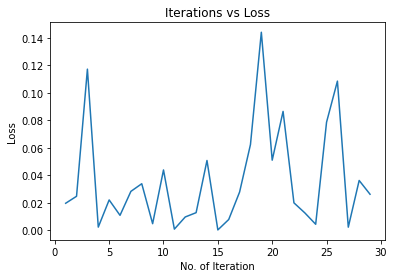

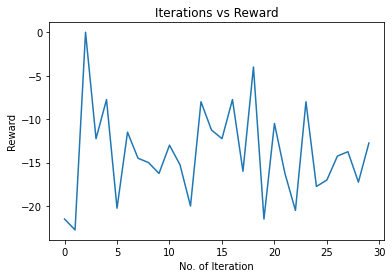

In [31]:
import matplotlib.pyplot as plt

loss_file = open('./src_old/data/loss_list_demo2.dat', 'r')
reward_file = open('./src_old/data/reward_sum_demo2.dat', 'r')

loss_list = []
reward_list = []

for loss in loss_file:
    loss_list.append(float(loss))

for reward in reward_file:
    reward_list.append(float(reward))

plt.figure(1)
plt.plot(list(range(len(loss_list))), loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")

plt.figure(2)
plt.plot(list(range(len(reward_list))), reward_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Reward")
plt.title("Iterations vs Reward")

plt.show()


因为上面的过程训练的比较慢，所以就在notebook上面训练了非常少的轮次，画出来的图也不是特别好，看不出损失下降或者奖励上升的趋势。

目前来说设计的DQN网络是没有问题的，因为从游戏情况来看确实是有根据奖励函数进行了学习的，甚至还会钻奖励函数的空子，比如只奖励最宽的那一行并且惩罚总体的高度，DQN很快就会学会把某一行尽可能的变宽，然后迅速的把高度叠上去。

但是因为奖励函数设计不合理或者其他因素，最后训练出来的效果也并不是很好。

### 测试DQN训练效果

训练的效果并不是很好。。

In [32]:
import gym_tetris
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

import src_old.report_04_tools as tools
from src_old.Tetris_DQN import DQN, MEMORY_CAPACITY

# Open AI gym提供了许多不同的环境。每一个环境都有一套自己的参数和方法。然而，他们通常由一个类Env包装（就像这是面向对象编程语言（OOPLs）的一个接口）。这个类暴露了任一环境的最常用的，最本质的方法，比如step
# ，reset，seed。拥有这个“接口”类非常好，因为它允许您的代码不受环境限制。如果您希望在不同的环境中测试单个代理，那么它还使事情变得更简单。然而，如果你想访问一个特定环境的场景动态后面的东西，需要使用unwrapped属性。
# 还原env的原始设置，env外包了一层防作弊层
# env = gym_tetris.make('TetrisA-v0').unwrapped
# 这里采用一种奖励分数惩罚身高的俄罗斯方块
env = gym_tetris.make('TetrisA-v1').unwrapped
env = JoypadSpace(env, SIMPLE_MOVEMENT)

dqn = DQN()
#dqn.load('./src_old/data/')  # 使用已有的模型继续训练
dqn.eval_net.load_state_dict(torch.load("./src_old/data/DQN_eval_net.pth"))
dqn.target_net.load_state_dict(torch.load("./src_old/data/DQN_target_net.pth"))

for i in range(5):  # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    last_state = env.reset()  # 重置环境
    last_state = tools.get_matrix(last_state)
    last_score = 0

    episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励

    while True:  # 开始一个episode (每一个循环代表一步)
        # if i % 100 == 0:
        #     env.render()  # 显示实验动画
        env.render()  # 显示实验动画
        action = dqn.choose_action(last_state)  # 输入该步对应的状态s，选择动作
        state, reward, done, info = env.step(action)  # 执行动作，获得反馈
        state = tools.get_matrix(state)
        # ===========================奖励修改部分===========================
        score = tools.score_policy_A(state)
        # reward = reward * 2  # 奖励消除行（这里可能还是需要修改！）
        # if score - last_score != 0:
        #     print(reward, score - last_score)
        # reward += score - last_score  # 这样对reward进行修改才是正确的！！！
        if reward != 0:
            print("消除了一行，得到：{} 分".format(reward))
        reward = reward * 5 + (score - last_score)  # 原始分数(消除的行数)+新分数
        last_score = score
        # =================================================================

        # ===========================参数修改部分===========================
        #
        # =================================================================
        episode_reward_sum += reward  # 逐步加上一个episode内每个step的reward

        last_state = state  # 更新状态
        last_action = action  # 更新动作

        if done:  # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            break

<<<<<<<<<Episode: 0
episode0---reward_sum: -20.75
<<<<<<<<<Episode: 1
episode1---reward_sum: -18.25
<<<<<<<<<Episode: 2
episode2---reward_sum: -20.25
<<<<<<<<<Episode: 3
episode3---reward_sum: -17.0
<<<<<<<<<Episode: 4
episode4---reward_sum: -21.0


## 尝试其他的俄罗斯方块环境

我发现无论怎么训练，在gym-tetris中，我训练的网络最多最多只能够把这个游戏界面给填满，但是一行都消不掉。

并且因为gym-tetris设计的不是很好，不可以自动下落，必须要输入对应的action才可以往下落。这样的话训练的效率很低，并且对网络来说也不是很友好，它还需要额外学习下落这个动作。

最关键的是，我无法直接从返回的数据中得出哪些方块是已经放置好的，哪些方块是正在下落的，这个对我的奖励函数的设计也有一些影响。

所以我打算尝试一下使用其他的俄罗斯方块环境来进行训练。

一开始我是考虑的在gym-tetris的基础上面进行修改，但是感觉这个东西不太好改，后面我找了一个基于pygame的俄罗斯方块实现，我把它的代码进行了封装，并且调整的尽可能和gym-tetris的用法相同。

我尝试的新俄罗斯方块环境和之前的gym-tetris主要有以下差别：

1. state矩阵从20\*10变成了21\*10。并且正在下落的方块被标记为2，已经放置的标记为1，未放置的标记为0。

2. 取消了下落这个动作，游戏会自动下落，这样可以加快训练速度，也可以让DQN更好的进行学习。

3. 可以动态的调节游戏速度，在训练的时候可以设置的快一点，测试的时候可以设置的慢一点。

下面是基于pygame的俄罗斯方块示例：

In [4]:
import Tetris as Game
import numpy as np
if __name__ == "__main__":
    env = Game.Tetris(5)
    # env.human_rander()
    for i in range(5):  # 演示5轮
        print('<<<<<<<<<Episode: %s' % i)
        s = env.reset()  # 重置环境
        # episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励
        while True:  # 开始一个episode (每一个循环代表一步)
            action = np.random.randint(0, 5)  # 输入该步对应的状态s，选择动作
            s_, r, done = env.machine_render(action)  # 执行动作，获得反馈

            # print(env.get_state())

            if done:  # 如果done为True
                # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
                print('episode%s---reward_sum: %s' % (i, round(r, 2)))
                break

<<<<<<<<<Episode: 0
episode0---reward_sum: 12
<<<<<<<<<Episode: 1
episode1---reward_sum: 22
<<<<<<<<<Episode: 2
episode2---reward_sum: 23
<<<<<<<<<Episode: 3
episode3---reward_sum: 23
<<<<<<<<<Episode: 4
episode4---reward_sum: 21


下面是新游戏运行过程中的截图：

<img src="./img/new_game1.png"/> 

### 修改DQN模型

在尝试新俄罗斯方块期间，我又了解到DQN的一些小技巧，根据网上的推荐，我给DQN设计了INIT_EPSILON和FINAL_EPSILON参数。

在开始训练的时候，这个DQN的epsilon取值为INIT_EPSILON，这个值比较低。这样DQN会更主要的进行随机尝试，这样可以防止DQN收敛到一个局部最优解而跳不出来。

而在训练的过程中，DQN的epsilon会慢慢往FINAL_EPSILON靠，这样DQN会越来越多的采取当前最优的动作，这样可以让DQN在后期取得一个比较好的效果的情况下更进一步。

相关的代码如下所示：

``` python
INIT_EPSILON = 0.0001  # init greedy policy
FINAL_EPSILON = 1  # last greedy policy

def update_epsilon(self, rate):
    if rate > 1:
        rate = 1
    if rate < 0:
        rate = 0
    self.epsilon = (FINAL_EPSILON - INIT_EPSILON) * rate + INIT_EPSILON
    
def choose_action(self, x):  # 定义动作选择函数 (x为状态)
    x = torch.unsqueeze(torch.FloatTensor(x), 0)
    if np.random.uniform() < self.epsilon:  # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0]
    else:  # 随机选择动作
        action = np.random.randint(0, N_ACTIONS)
    return action

```

### 修改奖励函数

我在这个新环境中尝试之前设计的奖励函数训练了几千轮，但是效果不是很好。后面我在github上发现了一个很好的项目：https://github.com/uvipen/Tetris-deep-Q-learning-pytorch ，他也是用DQN玩俄罗斯方块，并且训练过程中也采用了动态的epsilon，和我现在的状况非常接近。

我发现他设计的奖励函数非常简单，但是最后达到的很好的效果，所以我根据他的代码设计了一个新的奖励函数。

大致的思路是：

- 无论进行什么操作都给1分的奖励

- 当有一行或者多行被消除的时候再额外给更多的奖励

上面这个部分的核心代码其实就是一行：（因为要检测被消除的行数，所以我就把这个奖励放到Tetris的实现中了）

``` python
reward = 1 + (erase_count ** 2) * self.width
```

### 进行新的训练

> 具体的训练输出没有在notebook中展示。

In [1]:
import report_04_tools as tools
from Tetris_DQN import DQN, MEMORY_CAPACITY
import Tetris as Game

env = Game.Tetris(1)
dqn = DQN()
# dqn.load()

epoch = 3000
loss = float('inf')
loss_list = open('./data/loss_list.dat', 'w')
reward_sum = open('./data/reward_sum.dat', 'w')
lines_cleared = open('./data/lines_cleared.dat', 'w')

for i in range(epoch):
    dqn.update_epsilon(2 * (i - 1000) / epoch)  # 逐步的增大epsilon

    print('<<<<<<<<<Episode: %s' % i)
    last_state = env.reset()  # 重置环境
    last_score = 0

    episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励
    episode_lines_cleared = 0  # 消除的行数

    if i % 100 == 0 and i > 300:  # 防止i=0，还没开始训练的时候就保存模型
        print("save model")
        dqn.save()

    while True:  # 开始一个episode (每一个循环代表一步)
        action = dqn.choose_action(last_state)  # 输入该步对应的状态s，选择动作
        # state, _, done, erase_count = env.machine_render(action)  # 执行动作，获得反馈
        state, reward, done, erase_count = env.machine_render(action)  # 执行动作，获得反馈

        # ===========================奖励修改部分===========================
        # score = tools.score_policy_A(state)
        # reward = (score - last_score)  # 原始分数(消除的行数)+新分数
        # last_score = score
        # =================================================================

        # ===========================参数修改部分===========================
        #
        # =================================================================

        dqn.store_transition(last_state, action, reward, state)  # 存储样本
        episode_reward_sum += reward  # 逐步加上一个episode内每个step的reward
        episode_lines_cleared += erase_count

        last_state = state  # 更新状态
        # last_action = action  # 更新动作

        if dqn.memory_counter > MEMORY_CAPACITY:  # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            loss = dqn.learn()

        if done:  # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            print('episode%s---lines_cleared: %s' % (i, round(episode_lines_cleared, 2)))
            print('episode%s---loss: %s' % (i, loss))

            loss_list.write(str(loss) + "\n")
            reward_sum.write(str(episode_reward_sum) + "\n")
            lines_cleared.write(str(episode_lines_cleared) + "\n")

            break

loss_list.close()
reward_sum.close()
lines_cleared.close()


#### 可视化训练中损失与奖励

我在pycharm里面训练了一万轮次，并且把部分结果保存到了文件中，这样就可以把训练中的损失、奖励、消除行数可视化出来。

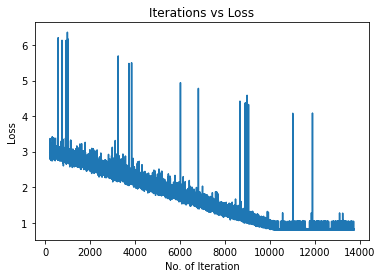

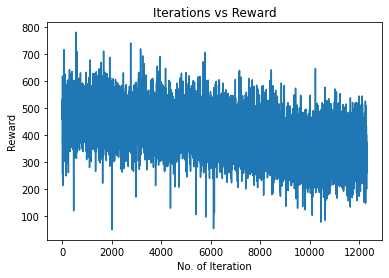

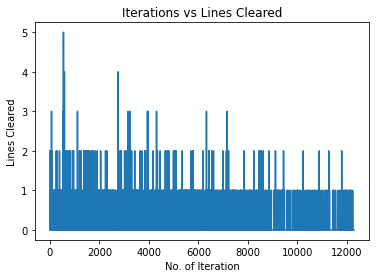

In [2]:
import matplotlib.pyplot as plt

loss_file = open('./src/data/round2/loss_list.dat', 'r')
reward_file = open('./src/data/round2/reward_sum.dat', 'r')
lines_file = open('./src/data/round2/lines_cleared.dat', 'r')

loss_list = []
reward_list = []
lines_list = []

for loss in loss_file:
    loss_list.append(float(loss))

for reward in reward_file:
    reward_list.append(float(reward))

for lines in lines_file:
    lines_list.append(float(lines))

plt.figure(1)
plt.plot(list(range(len(loss_list))), loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")

plt.figure(2)
plt.plot(list(range(len(reward_list))), reward_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Reward")
plt.title("Iterations vs Reward")

plt.figure(3)
plt.plot(list(range(len(lines_list))), lines_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Lines Cleared")
plt.title("Iterations vs Lines Cleared")

plt.show()


从上面的结果可以看出来，损失大体上是下降了的，但是后面几乎不收敛了，所以后面应该要尝试更小一点的学习率。

而消除的行数和奖励基本上变化不大，我感觉应该是训练的轮次太少了，如果随机的轮次再多一些，训练的轮次也再多一些，应该后面DQN是可以学会的。

## 尝试基于规则的算法

打算了解的方向有：

1. 有限状态机

2. 一些搜索算法

3. Q-Learning（这个是学习的方法，但是比DQN更简单，因为状态不是很多，所以这个方法也可以用）

4. Pierre Dellacherie（这是目前了解到的效果最好的算法）

因为之前因为无论怎么设计奖励函数，甚至更换训练环境也没有让DQN训练出来一个比较好的结果，期间花费了比较多的时间，这个部分不是很有时间来尝试了。其实当时也考虑了先实现基于规则的算法，之后再利用基于规则的算法产生一些数据给DQN进行学习，之后再让DQN自己学习从而超越非学习算法的，但还是把精力放在了奖励函数的设计上面，耽误了比较多的时间！

## 总结

这个大作业感觉是六个可选的里面最有意思的，但是感觉难度非常高。我觉得这个任务中，**最核心最关键的其实是奖励函数的设计** ，可惜的是我实在没有找到一个比较好的奖励函数来让DQN训练出一个比较好的结果来。

**奖励函数对DQN的影响非常大，DQN很容易钻奖励函数的空子，而复杂的奖励函数DQN很难学习。** 

比如我写一个奖励最大宽度和惩罚最大高度的奖励函数，DQN确实会想办法把宽度变大，但是因为是最大宽度，所以有时候DQN把一行填的差不多满了，然后就直接叠高度去了，因为已经有一行宽度足够大了，没必要把别的行宽度也增大。

再比如我写一个复杂点的，奖励放置了6个方块以上的行数，惩罚最大高度，惩罚不平整度（相邻两列的高度差）。这样的话，DQN训练到后面，就会从一侧开始放置方块，比如从左往右放方块，左边的列放满了再开始往右边放，如下图。

<img src="./img/test_demo3.png" alt="result"  width="300px" />

但是我发现奖励函数不能写太复杂了，太复杂了之后，DQN可能就学习不到什么步骤才是好的，并不能很好地拿到分数。

所以后面我都是用一些相对简单的奖励函数来进行训练，简单的奖励函数DQN能学习到，但是又很容易钻空子。

我尝试了四五天，也**没找到一个又简单又能保证DQN好好训练的奖励函数，我觉得这应该是我训练效果不好的主要原因**。

最后我得到的训练结果大概是下面这种样子的，能够尽量的放满，但是很难消除一行。

<img src="./img/test_demo2.png" alt="result"  width="300px" />

<img src="./img/test_demo1.png" alt="result"  width="300px" />

另外，我尝试了新的俄罗斯方块环境，在新的环境里面可以让训练更快，并且训练的结果也比gym-tetris的要稍微好一些。唯一的问题就是这是我从别人的代码修改过来的，BUG比较多，前期进行训练的时候可能跑个几十几百轮就会报错，后面慢慢把BUG修复了才能够一次训练上万轮。

我发现**不管采用的训练环境怎么样，奖励函数都对最后的训练结果有非常大的影响，同样的奖励函数下，不同环境训练出来的网络也会跑出相似的结果来。**

尝试新环境的时候还在网上找到一个非常好的参考，它的奖励函数非常简单，并且它也是按照这个奖励函数训练，最后取得了比较好的效果。我效仿了一下它的奖励函数和训练过程，不过可能因为训练的轮次不够或者是某些参数没有调整好，训练几万轮后并没有达到一局游戏消除非常多行的效果。

我最后达到的效果是下面这样的：

<img src="./img/new_game3.png" />

<img src="./img/new_game4.png" />